In [1]:
%load_ext autoreload
%autoreload 2

import pyVHR as vhr
import numpy as np
from pyVHR.analysis.pipeline import Pipeline
from pyVHR.plot.visualize import *
import os
import plotly.express as px
from pyVHR.utils.errors import getErrors, printErrors, displayErrors
from pyVHR.extraction.utils import CustomLandmarks
import pyVHR.analysis.pipelineLandmarks as custom_pipeline

import constants
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects


vhr.plot.VisualizeParams.renderer = 'vscode' 

In [2]:
landmarks = CustomLandmarks()
all_landmarks = list(landmarks.get_all_landmarks().keys())

# Defining the color palette
palette = sns.color_palette("Set3", n_colors=len(all_landmarks))
palette = dict(zip(all_landmarks, palette))

In [ ]:
import os 

files = os.listdir(f'../results/test_landmarks/h5/{dataset_name}/')
print("There are ", len(files), " files in the folder")
df = pd.DataFrame()
for file in files:
    x = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/'+file, key='df')
    break

In [ ]:
rois = {
  'forehead': [   
      'lower_medial_forehead','glabella','left_lower_lateral_forehead','right_lower_lateral_forehead'
    ],
 'nose': [
    'upper_nasal_dorsum','lower_nasal_dorsum','left_mid_nasal_sidewall','right_mid_nasal_sidewall','left_lower_nasal_sidewall',
    'right_lower_nasal_sidewall','nasal_tip','soft_triangle','left_ala','right_ala'
  ],
  'cheeks':[
    'left_malar','right_malar', 'left_lower_cheek','right_lower_cheek'
  ],
  'jaw':[
    'left_marionette_fold','right_marionette_fold','chin'
  ],
  'temple':[
    'left_temporal','right_temporal'
  ],
  'mustache':[
    'left_nasolabial_fold','right_nasolabial_fold','left_upper_lip','right_upper_lip','philtrum'
  ],
}
rois['forehead']

df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_each_landmark.h5')
df = df.drop(columns=['sigFilename'])
from fastdtw import fastdtw
df.insert(11, 'DTW', None)
for row in df.itertuples():
  distance, path = fastdtw(row.bpmGT, row.bpmES)
  df.loc[row.Index, 'DTW'] = [distance]
df['videoFilename'] = df['videoFilename'].apply(lambda x: x.split('\\')[2])
for roi in list(rois.keys()):
    df.loc[ df['landmarks'].apply(lambda x: x[0]).isin(rois[f'{roi}']),'dataset'] = f'{dataset_name.lower()}_{roi}'
df['landmarks'] = df['landmarks'].apply(lambda x: tuple(x))
df.head(5)

# Functions

In [3]:
def get_data_each_landmark(df, metric, dataset_name):
    ### Get data
    if type(df['landmarks'].iloc[0]) != str:
        df['landmarks'] = df['landmarks'].apply(lambda x: x[0])
    if df[metric].dtype == 'object':
        df[metric] = df[metric].apply(lambda x: x[0])
    if dataset_name == 'MR_NIRP':
        df['video'] = df.videoFilename.apply(lambda x: x.split('_')[1])
        df['person'] = df.videoFilename.apply(lambda x: x.split('_')[0])
    elif dataset_name == 'LGI_PPGI':
        df['video'] = df['videoFilename'].apply(lambda x: x.split('_')[-1])
        df['person'] = df.videoFilename.apply(lambda x: x.split('_')[0])
    else:
        print("Video and person format not defined for ", dataset_name)

    return df

def plot_boxplot_each_landmark(df, metric, dataset_name, ax=None):
    # Determin median metric order
    grouped = df[['landmarks', metric]].groupby('landmarks').median().sort_values(by=metric)

    if ax is None:
        ax = plt.gca()
    box = sns.boxplot(x='landmarks', y=metric, data=df, order=grouped.index, palette=palette, hue='landmarks', legend='brief', ax=ax)
    box.legend_.remove()
    labels = [item.get_text().replace('_', ' ')  for item in box.get_xticklabels()]
    box.set_xticks(range(len(labels)))
    box.set_xticklabels(labels,rotation=90, fontsize=7)
    box.set_title(f"Boxplot of average MAE for individual landmarks ({dataset_name.upper()})")

    return grouped, box

def plot_histogram_each_landmark(df, metric, dataset_name, ax=None):
    # Determin median metric order
    rankings = df.groupby('videoIdx')[metric].rank(ascending=True).groupby(df['landmarks']).mean().sort_values().reset_index()
    
    if ax is None:
        ax = plt.gca()
    bar = sns.barplot(x=metric, y='landmarks', data=rankings, palette=palette, hue='landmarks', ax=ax)
    labels = [item.get_text().replace('_', ' ')  for item in ax.get_yticklabels()]
    bar.set_yticks(range(len(labels)))
    bar.set_yticklabels(labels, fontsize=6)
    bar.set_title(f"Average rankings of the MAE values for individual landmarks ({dataset_name.upper()})")

    return rankings, bar

def plot_each_landmark(df, metric, dataset_name, axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    df = get_data_each_landmark(df, metric, dataset_name)
    grouped, box = plot_boxplot_each_landmark(df, metric, dataset_name, axs[0])
    rankings, bar = plot_histogram_each_landmark(df, metric, dataset_name, axs[1])

    return df, grouped, rankings, box, bar

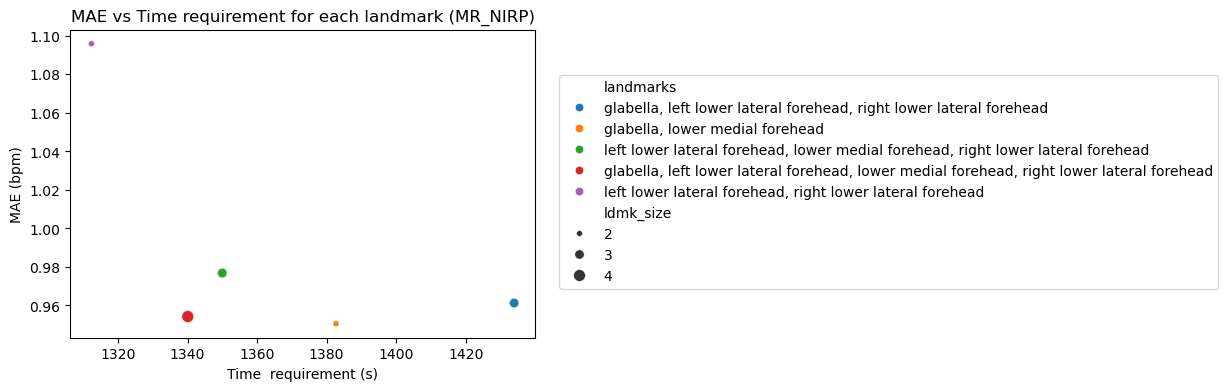

In [ ]:
import plotly.express as px
roi = 'forehead'
metric = 'MAE'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
if df[metric].dtype == 'object':
    df[metric] = df[metric].apply(lambda x: x[0])
if dataset_name == 'MR_NIRP':
    df['video'] = df.videoFilename.apply(lambda x: x.split('_')[1])
if dataset_name == 'LGI_PPGI':
    df['video'] = df['videoFilename'].apply(lambda x: x.split('_')[-1])
df['ldmk_time'] = df.groupby('landmarks')['TIME_REQUIREMENT'].transform('sum')
df['ldmk_MAE'] = df.groupby('landmarks')['MAE'].transform('mean')
df['ldmk_size'] = df['landmarks'].apply(lambda x: len(x))
df['landmarks'] = df.landmarks.apply(lambda x: ', '.join(x).replace('_',' ').replace('(','').replace(')',''))

fig, ax = plt.subplots(figsize=(6, 4))
# TODO increase size difference
ax = sns.scatterplot(data=df, x='ldmk_time', y='ldmk_MAE', hue='landmarks', size='ldmk_size')
ax.set(xlabel='Time  requirement (s)', ylabel='MAE (bpm)', title=f"MAE vs Time requirement for each landmark ({dataset_name.upper()})")
ax.legend_.remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,labels, loc='right', bbox_to_anchor=(2.05, 0.5), ncol=1)
plt.show()

# fig = px.scatter(df, x="ldmk_time", y="ldmk_MAE", color='landmarks', size='ldmk_size', hover_name="landmarks")  # color="continent",log_x=True, 
## fig = px.scatter(df, x="TIME_REQUIREMENT", y="MAE", color='videoFilename', hover_name="landmarks")  # color="continent",log_x=True, 
# fig.show()

In [4]:
def get_palette(df):
    # Defining the color palette
    palette = sns.color_palette("Set3", n_colors=len(df['landmarks_id'].unique()))
    palette = dict(zip(df['landmarks_id'].unique(), palette))
    return palette

def get_handle_labels(df, axes):
    handles_labels = [ax.get_legend_handles_labels() for ax in axes]
    landamarks_mapping = df[['landmarks','landmarks_id']].drop_duplicates().sort_values(by='landmarks_id')
    if type(landamarks_mapping['landmarks'][0]) == tuple:
        landamarks_names = [', '.join([name.replace('_', ' ') for name in names]) for names in landamarks_mapping['landmarks'].values]
    else:
        landamarks_names = [name.replace('_', ' ') for name in landamarks_mapping['landmarks'].values]
    landamarks_mapping = dict(zip(landamarks_mapping['landmarks_id'].values, landamarks_names))
    handles = [None] * len(df['landmarks_id'].unique())
    # labels = np.arange(0,len(df['landmarks_id'].unique()))
    labels = [None] * len(df['landmarks_id'].unique())
    for (handle_label) in handles_labels:
        for i,(h,l) in enumerate(zip(*handle_label)):
            if  handles[int(l)] is None:
                handles[int(l)] = h
                labels[int(l)] = l+':'+str(landamarks_mapping[int(l)])
    return handles, labels

def get_rankings_roi(df, dataset_name, metric='MAE'):
    if df[metric].dtype == 'object':
        df[metric] = df[metric].apply(lambda x: x[0])
    if dataset_name == 'MR_NIRP':
        df['video'] = df.videoFilename.apply(lambda x: x.split('_')[1])
    if dataset_name == 'LGI_PPGI':
        df['video'] = df['videoFilename'].apply(lambda x: x.split('_')[-1])
    df['score'] = df.groupby(['video','landmarks']).MAE.transform('mean')
    df = df.reset_index(drop=True)

    rankings = df.sort_values(['video','score']).drop_duplicates(['video','score']).groupby(['video']).head(5)
    rankings['landmarks_id'] = rankings['landmarks'].astype('category').cat.codes
    rankings = rankings[['video', 'videoIdx', 'landmarks','landmarks_id','MAE', 'RMSE', 'PCC','score']]

    return df, rankings

def plot_bar_roi(df, rankings, roi, dataset_name, ncol=1, fig=None, axs=None):

    if fig is None:
        fig, axs = plt.subplots(1,len(df.video.unique()), figsize=(15,5))

    palette = get_palette(rankings)
    for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
        video = df.video.unique()[i]
        df_video = rankings[rankings.video==video]
        bar = sns.barplot(x='landmarks_id', y='score', data=df_video, ax=ax, hue='landmarks_id', palette=palette)
        for container in ax.containers:
            bar.bar_label(container, fmt='%.1f', padding=-15)
        bar.set(xlabel=None, ylabel=None)
        if i < len(df.video.unique()) - 2:
            bar.set(xlabel=None, ylabel=None, xticks=[])
        bar.legend_.remove()
        bar.set_title(video)
    fig.supxlabel("Landmarks ID")
    fig.supylabel("Average MAE", x= 0.08)
    fig.suptitle(f"Landmarks with highest average MAE per video category for ROI = {roi} ({dataset_name}))")
    handles, labels = get_handle_labels(rankings, fig.axes)
    fig.legend(handles,labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)


    return fig, axs

def add_median_labels(ax, medians, fmt=".1f") -> None:
    # vertical_offset = df_video['MAE'].median() * 0.03 # offset from median for display
    lines = ax.get_lines()
    for i,xtick in enumerate(ax.get_xticks()):
        text = ax.text(xtick, medians[xtick], medians[xtick], color='white',
                        horizontalalignment='center', verticalalignment='center', fontsize=9) # color='b',weight='semibold' size='x-small'
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground=lines[i].get_color()),
            path_effects.Normal(),
        ])
        # ax.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
        #         horizontalalignment='center', size='x-small') # color='b',weight='semibold'

def plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=None, axs=None):
    
    if fig is None:
        fig, axs = plt.subplots(1,len(df.video.unique()), figsize=(15,5))

    df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
    palette = get_palette(df)
    for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
        video = df.video.unique()[i]
        landmarks_ids = rankings[rankings.video==video]['landmarks_id']
        df_video = df[df.video==video].query('landmarks_id in @landmarks_ids')
        ax = sns.boxplot(x='landmarks_id', y='MAE', data=df_video, ax=ax, hue='landmarks_id', palette=palette)
        ax.set(xlabel=None, ylabel=None)
        ax.legend_.remove()
        ax.set_title(video)

        medians = df_video.groupby(['landmarks_id'])['MAE'].median().round(2)
        add_median_labels(ax, medians)
        if i < len(df.video.unique()) - 2:
            ax.set(xlabel=None, ylabel=None, xticks=[])
    fig.supxlabel("Landmarks ID")
    fig.supylabel("MAE", x= 0.08)
    fig.suptitle(f"Landmarks with highest average MAE per video category for ROI = {roi} ({dataset_name})")
    handles, labels = get_handle_labels(rankings, fig.axes)
    fig.legend(handles,labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)

    return fig, axs

# LGI-PPGI

In [5]:
# -- LOAD A DATASET

dataset_name = 'LGI_PPGI'    
video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames
wsize = 8        # seconds of video processed (with overlapping) for each estimate 
fps = vhr.extraction.get_fps(dataset.getSigFilename(0))


# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])

0 D:/datasets_rppg/LGI_PPGI\alex\alex_gym\cv_camera_sensor_stream_handler.avi
1 D:/datasets_rppg/LGI_PPGI\alex\alex_resting\cv_camera_sensor_stream_handler.avi
2 D:/datasets_rppg/LGI_PPGI\alex\alex_rotation\cv_camera_sensor_stream_handler.avi
3 D:/datasets_rppg/LGI_PPGI\alex\alex_talk\cv_camera_sensor_stream_handler.avi
4 D:/datasets_rppg/LGI_PPGI\angelo\angelo_gym\cv_camera_sensor_stream_handler.avi
5 D:/datasets_rppg/LGI_PPGI\angelo\angelo_resting\cv_camera_sensor_stream_handler.avi
6 D:/datasets_rppg/LGI_PPGI\angelo\angelo_rotation\cv_camera_sensor_stream_handler.avi
7 D:/datasets_rppg/LGI_PPGI\angelo\angelo_talk\cv_camera_sensor_stream_handler.avi
8 D:/datasets_rppg/LGI_PPGI\cpi\cpi_gym\cv_camera_sensor_stream_handler.avi
9 D:/datasets_rppg/LGI_PPGI\cpi\cpi_resting\cv_camera_sensor_stream_handler.avi
10 D:/datasets_rppg/LGI_PPGI\cpi\cpi_rotation\cv_camera_sensor_stream_handler.avi
11 D:/datasets_rppg/LGI_PPGI\cpi\cpi_talk\cv_camera_sensor_stream_handler.avi
12 D:/datasets_rppg/LGI_

In [6]:
rois = {
  'forehead': [   
      'lower_medial_forehead','glabella','left_lower_lateral_forehead','right_lower_lateral_forehead'
    ],
 'nose': [
    'upper_nasal_dorsum','lower_nasal_dorsum','left_mid_nasal_sidewall','right_mid_nasal_sidewall','left_lower_nasal_sidewall',
    'right_lower_nasal_sidewall','nasal_tip','soft_triangle','left_ala','right_ala'
  ],
  'cheeks':[
    'left_malar','right_malar', 'left_lower_cheek','right_lower_cheek'
  ],
  'jaw':[
    'left_marionette_fold','right_marionette_fold','chin'
  ],
  'temple':[
    'left_temporal','right_temporal'
  ],
  'mustache':[
    'left_nasolabial_fold','right_nasolabial_fold','left_upper_lip','right_upper_lip','philtrum'
  ],
}
rois['forehead']

df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_each_landmark.h5')
df = df.drop(columns=['sigFilename'])
from fastdtw import fastdtw
df.insert(11, 'DTW', None)
for row in df.itertuples():
  distance, path = fastdtw(row.bpmGT, row.bpmES)
  df.loc[row.Index, 'DTW'] = [distance]
df['videoFilename'] = df['videoFilename'].apply(lambda x: x.split('\\')[2])
for roi in list(rois.keys()):
    df.loc[ df['landmarks'].apply(lambda x: x[0]).isin(rois[f'{roi}']),'dataset'] = f'{dataset_name.lower()}_{roi}'
df['landmarks'] = df['landmarks'].apply(lambda x: tuple(x))
df.head(5)

,method,dataset,videoIdx,videoFilename,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,DTW,bpmGT,bpmES,bpmES_mad,timeGT,timeES,TIME_REQUIREMENT,landmarks
0,CHROM,lgi_ppgi_forehead,0,alex_gym,[18.85158658158916],[10.145047075320512],[0.7553941615464782],[0.7195200625268386],[-2.5228200496543045],[87.462890625],"[1.0986328125, 1.8310546875, 2.9296875, 8.4228...",[3463.861328125],"[101.0, 100.0, 97.0, 94.5, 93.0, 93.0, 93.0, 9...","[54.5654296875, 54.931640625, 52.001953125, 57...",,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",,"(lower_medial_forehead,)"
1,POS,lgi_ppgi_forehead,0,alex_gym,[17.28631091326459],[7.554074018429487],[0.7925660926919266],[0.7604566024572632],[-1.0966366138921166],[96.44921875],"[1.46484375, 1.0986328125, 20.1416015625, 2.19...",[2261.42578125],"[101.0, 100.0, 97.0, 94.5, 93.0, 93.0, 93.0, 9...","[45.0439453125, 49.4384765625, 69.9462890625, ...",,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",,"(lower_medial_forehead,)"
2,LGI,lgi_ppgi_forehead,0,alex_gym,[18.477307030990016],[9.550438201121795],[0.7714946909592921],[0.7309077132180148],[-2.374374221210765],[76.16015625000001],"[1.0986328125, 20.1416015625, 1.46484375, 15.0...",[3086.8076171875],"[101.0, 100.0, 97.0, 94.5, 93.0, 93.0, 93.0, 9...","[54.19921875, 69.9462890625, 91.9189453125, 78...",,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",,"(lower_medial_forehead,)"
3,CHROM,lgi_ppgi_forehead,1,alex_resting,[1.5069460098847287],[0.9984611742424242],[0.930281429250698],[0.9237951473554368],[4.6233767029039115],[5.2353515625],"[0.3662109375, 0.3662109375, 0.3662109375, 0.3...",[40.79687499999999],"[68.5, 68.5, 68.0, 67.0, 67.0, 67.0, 67.0, 66....","[67.3828125, 68.115234375, 68.115234375, 67.01...",,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",,"(lower_medial_forehead,)"
4,POS,lgi_ppgi_forehead,1,alex_resting,[1.3306827606070688],[0.9583333333333333],[0.9566183478609336],[0.9451128749589376],[5.117704094401702],[4.20703125],"[0.0, 0.0, 0.3662109375, 0.3662109375, 0.0, 0....",[48.16406249999999],"[68.5, 68.5, 68.0, 67.0, 67.0, 67.0, 67.0, 66....","[67.3828125, 68.115234375, 68.115234375, 66.65...",,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",,"(lower_medial_forehead,)"


## Boxplot by landmark

Reding  ../results/test_landmarks/h5/LGI_PPGI/LGI_PPGI_each_landmark.h5


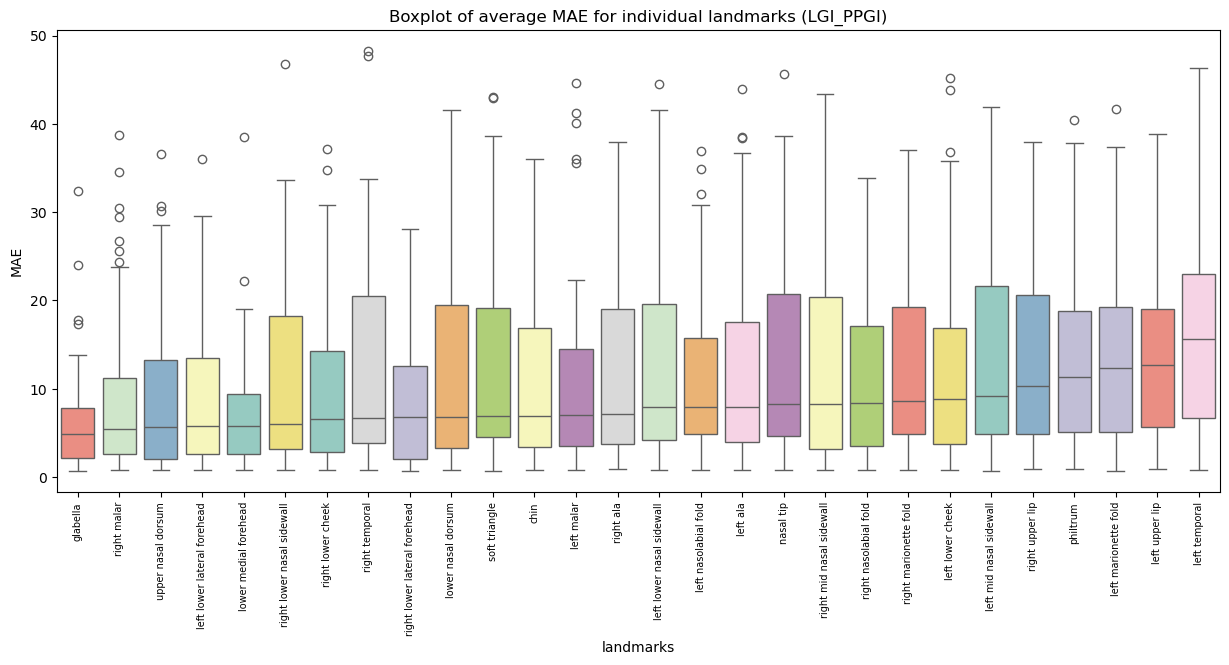

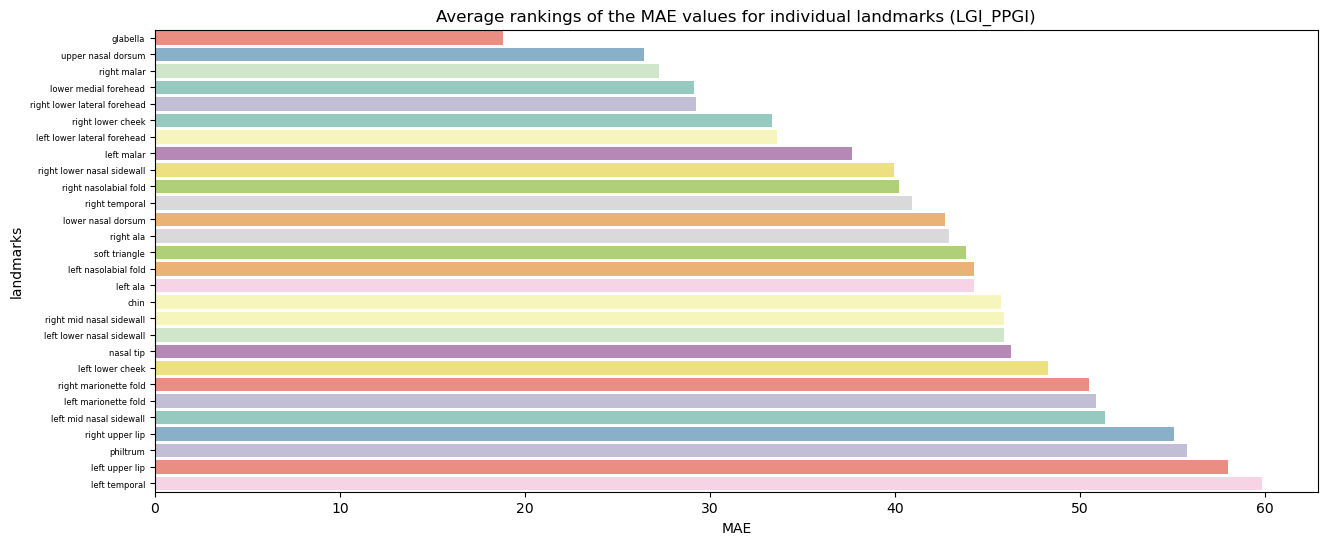

In [6]:
path_results = f"../results/test_landmarks/h5/{dataset_name}/" # general path for cfg# general path for data
filenameH5 = path_results + f"{dataset_name}_each_landmark" + ".h5"
metric = 'MAE'

print("Reding ", filenameH5)

df =  pd.read_hdf(filenameH5)
_, ax1 = plt.subplots(1,1, figsize=(15,6))
_, ax2 = plt.subplots(1,1, figsize=(15,6))
df, grouped, rankings, box, bar = plot_each_landmark(df, metric, dataset_name, [ax1,ax2])

# df = df.query('person != "felix"')
# print("I am taking out felix videos because fuck them")
# df = df.query('video != "gym"')
# print("I am taking out gym videos because fuck them")

In [7]:
# Worst performing video on each video setting
df.query("landmarks == 'glabella'").query('method == "CHROM"').sort_values('MAE', ascending=False).groupby('video').head(1)

,method,dataset,videoIdx,sigFilename,videoFilename,RMSE,MAE,PCC,CCC,SNR,...,MAD,bpmGT,bpmES,bpmES_mad,timeGT,timeES,TIME_REQUIREMENT,landmarks,video,person
252,CHROM,LGI_PPGI,20,,D:/datasets_rppg/lgi_ppgi\harun\harun_gym\cv_c...,[42.80714367317885],32.397053,[-0.07442693095141334],[-0.03090422630544887],[-5.070012055500783],...,"[0.732421875, 2.197265625, 5.4931640625, 26.73...","[99.5, 99.0, 98.5, 100.0, 102.5, 105.0, 105.5,...","[54.931640625, 55.2978515625, 57.12890625, 78....",,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",,glabella,gym,harun
228,CHROM,LGI_PPGI,11,,D:/datasets_rppg/lgi_ppgi\cpi\cpi_talk\cv_came...,[20.23307701007192],17.823664,[0.18742090091012117],[0.05505452028612498],[-3.9550230718167447],...,"[1.8310546875, 0.732421875, 2.9296875, 3.29589...","[71.0, 72.0, 73.5, 76.5, 80.5, 85.5, 89.5, 90....","[54.931640625, 55.2978515625, 89.35546875, 87....",,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",,glabella,talk,cpi
258,CHROM,LGI_PPGI,22,,D:/datasets_rppg/lgi_ppgi\harun\harun_rotation...,[16.010701405515054],10.690833,[0.24877433478585753],[0.06151786089665611],[-1.1344514451255756],...,"[0.3662109375, 0.732421875, 1.46484375, 0.7324...","[87.5, 88.5, 90.5, 91.5, 90.5, 88.0, 85.0, 82....","[90.8203125, 89.35546875, 87.158203125, 83.496...",,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",,glabella,rotation,harun
243,CHROM,LGI_PPGI,17,,D:/datasets_rppg/lgi_ppgi\felix\felix_resting\...,[5.566763594865538],5.109918,[0.05593953167019054],[0.006516580670828737],[14.234547471952817],...,"[0.3662109375, 0.0, 0.0, 0.0, 0.732421875, 0.0...","[56.0, 55.0, 53.5, 52.0, 51.5, 51.5, 51.5, 51....","[47.2412109375, 47.607421875, 47.607421875, 47...",,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",,glabella,resting,felix


## Compare by video setting

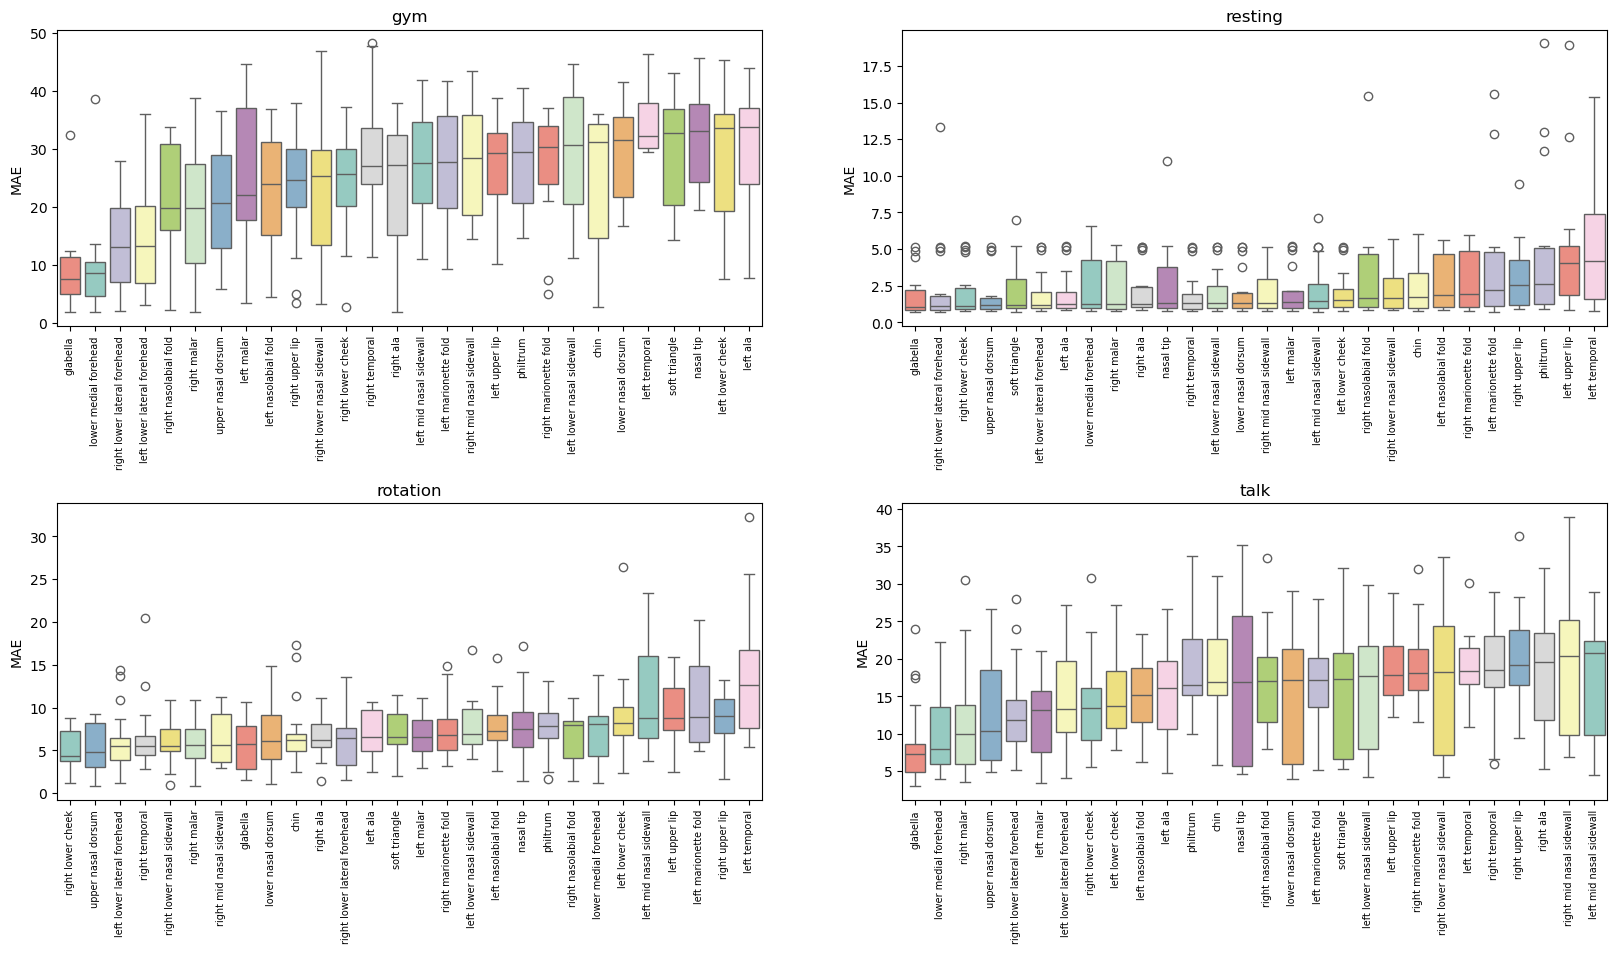

In [167]:
fig, axs = plt.subplots(2,2, figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
# fig.tight_layout()
videos = df.video.unique()
for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
   df_video = df.loc[df['video'] == videos[i]].copy()
   df_video = get_data_each_landmark(df_video, metric, dataset_name)
   _, box = plot_boxplot_each_landmark(df_video, metric, dataset_name, ax)
   box.set(title=videos[i], xlabel=None)
plt.show()

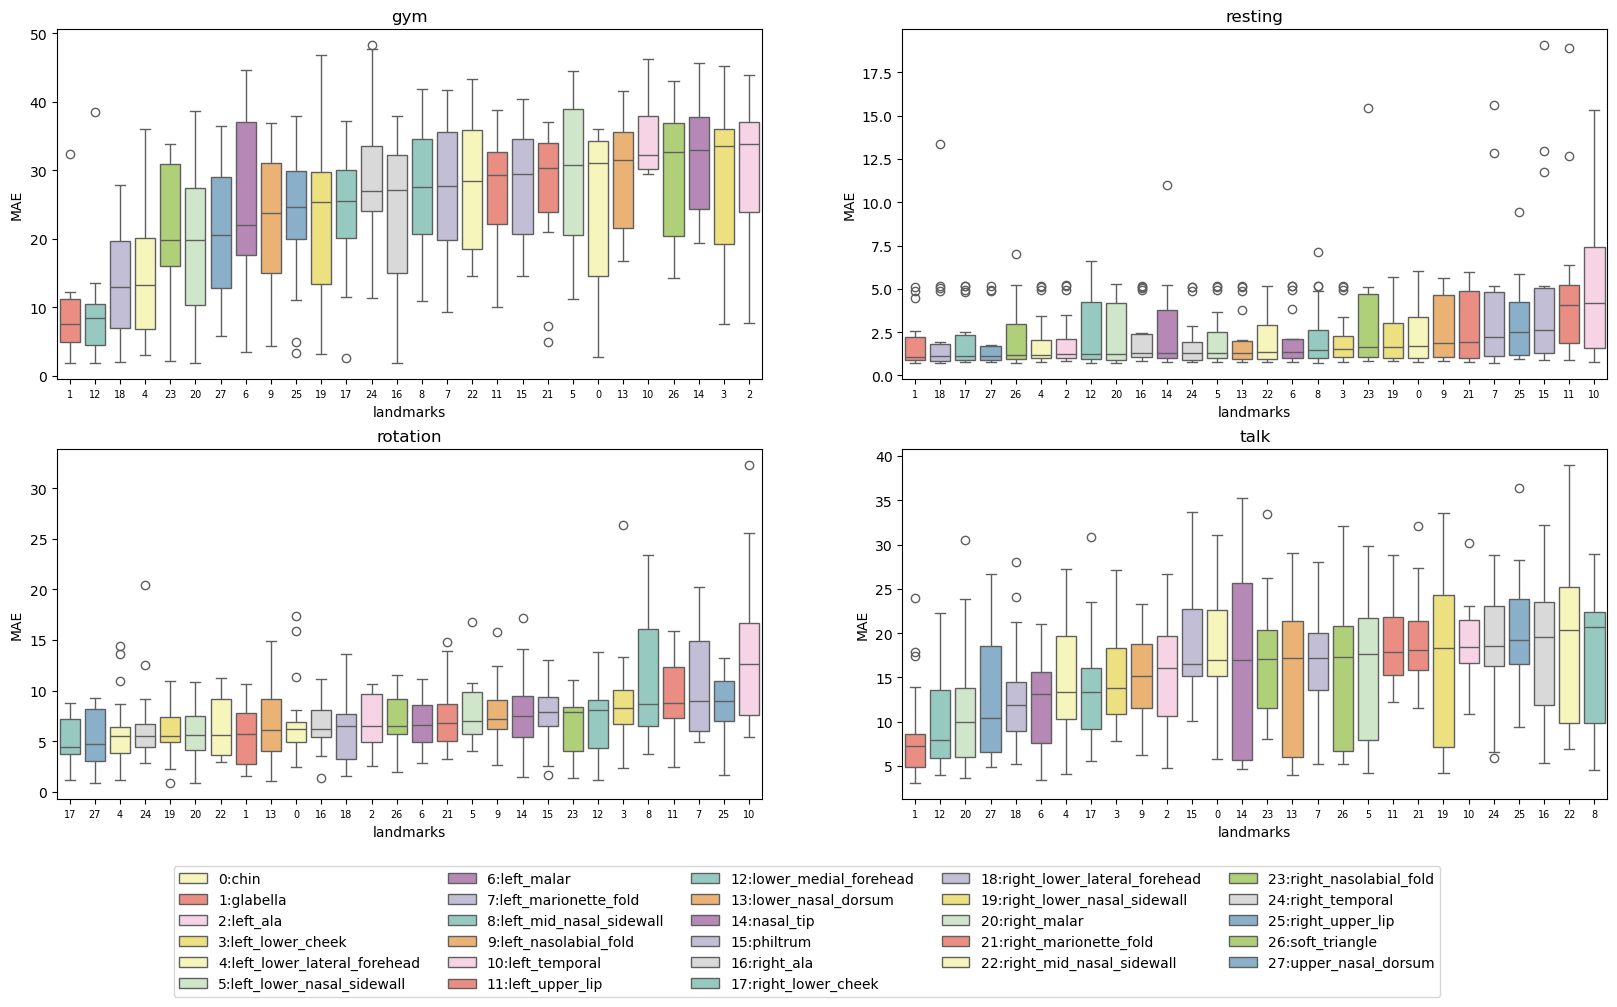

In [153]:
df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
landmarks_mapping = df[['landmarks','landmarks_id']].drop_duplicates().sort_values(by='landmarks_id')
landmarks_mapping = dict(zip(landmarks_mapping['landmarks'].values, landmarks_mapping['landmarks_id'].values))

fig, axs = plt.subplots(2,2, figsize=(20,10))
videos = df.video.unique()
for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
   df_video = df.loc[df['video'] == videos[i]].copy()
   df_video = get_data_each_landmark(df_video, metric, dataset_name)
   _, box = plot_boxplot_each_landmark(df_video, metric, dataset_name, ax)
   old_labels = [item.get_text().replace(' ', '_')  for item in box.get_xticklabels()]
   new_labels = [landamarks_mapping[label] for label in old_labels]
   box.set_xticks(range(len(new_labels)))
   box.set_xticklabels(new_labels,rotation=0, fontsize=7)
   box.set(title=videos[i])
handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
handles = [None] * len(df['landmarks_id'].unique())
labels = [None] * len(df['landmarks_id'].unique())
for (handle_label) in handles_labels:
    for i,(h,l) in enumerate(zip(*handle_label)):
        if  handles[landmarks_mapping[l]] is None:
            handles[landmarks_mapping[l]] = h
            labels[landmarks_mapping[l]] = str(landmarks_mapping[l])+':'+l
fig.legend(handles,labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5)
plt.show()

## Compare ROI by video setting

### Forehead

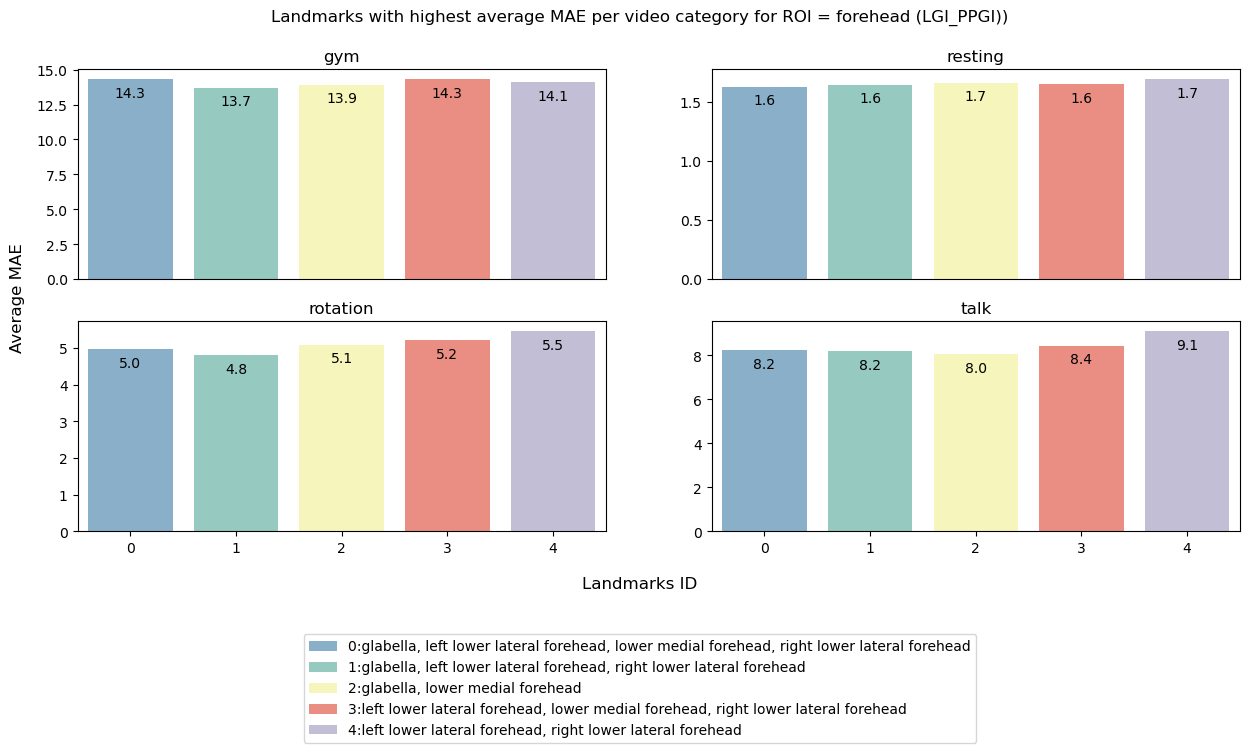

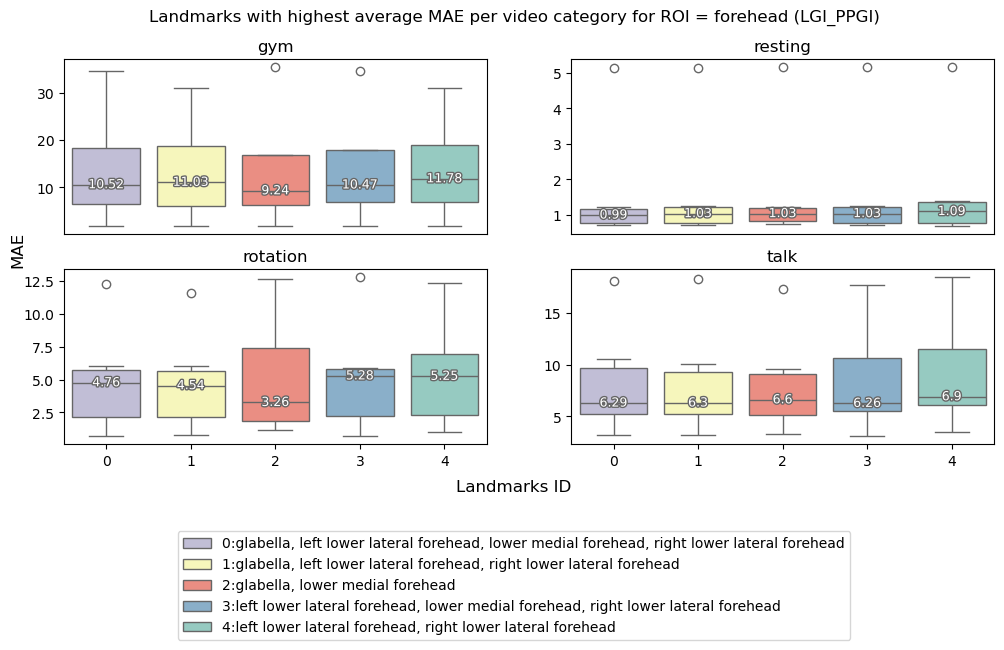

In [20]:
roi = 'forehead'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
forehead_params = [('left_lower_lateral_forehead', 'right_lower_lateral_forehead'), ('glabella', 'lower_medial_forehead'),  ('left_lower_lateral_forehead', 'lower_medial_forehead', 'right_lower_lateral_forehead'),('glabella', 'left_lower_lateral_forehead', 'right_lower_lateral_forehead'),('glabella', 'left_lower_lateral_forehead', 'lower_medial_forehead', 'right_lower_lateral_forehead')]
df = df.query('landmarks in @forehead_params')
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(2,2,figsize=(15,6))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(2,2,figsize=(12,5))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

### Cheeks

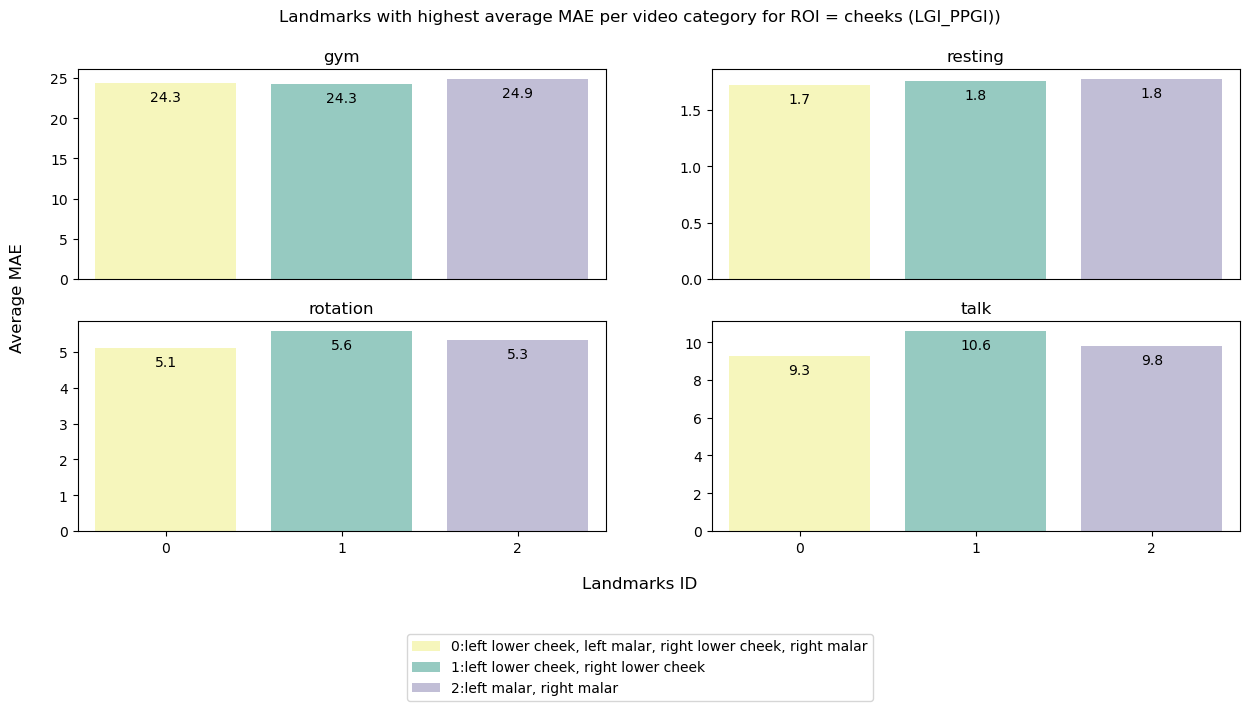

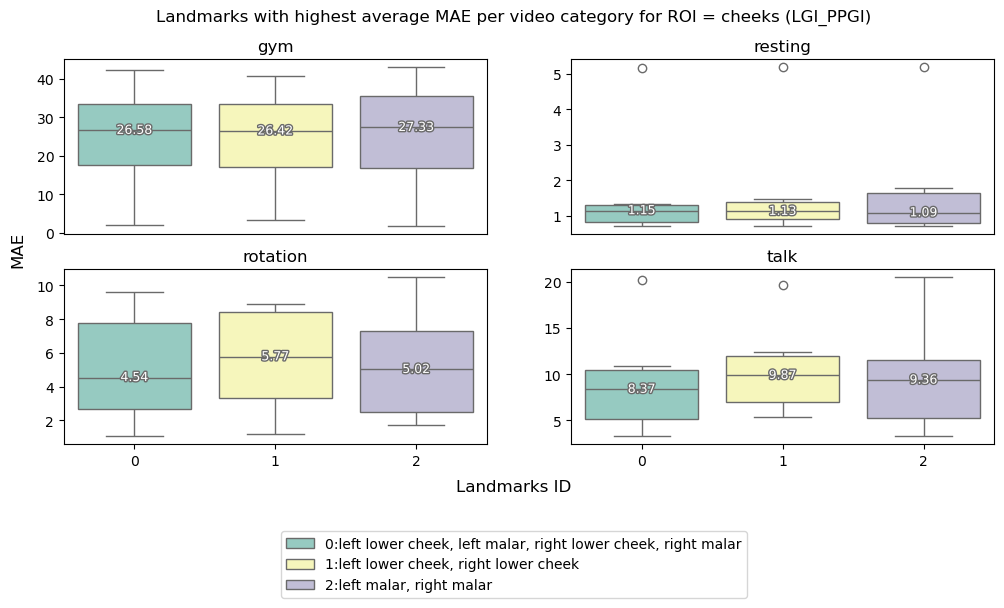

In [21]:
roi = 'cheeks'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(2,2,figsize=(15,6))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(2,2,figsize=(12,5))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

### Jaw

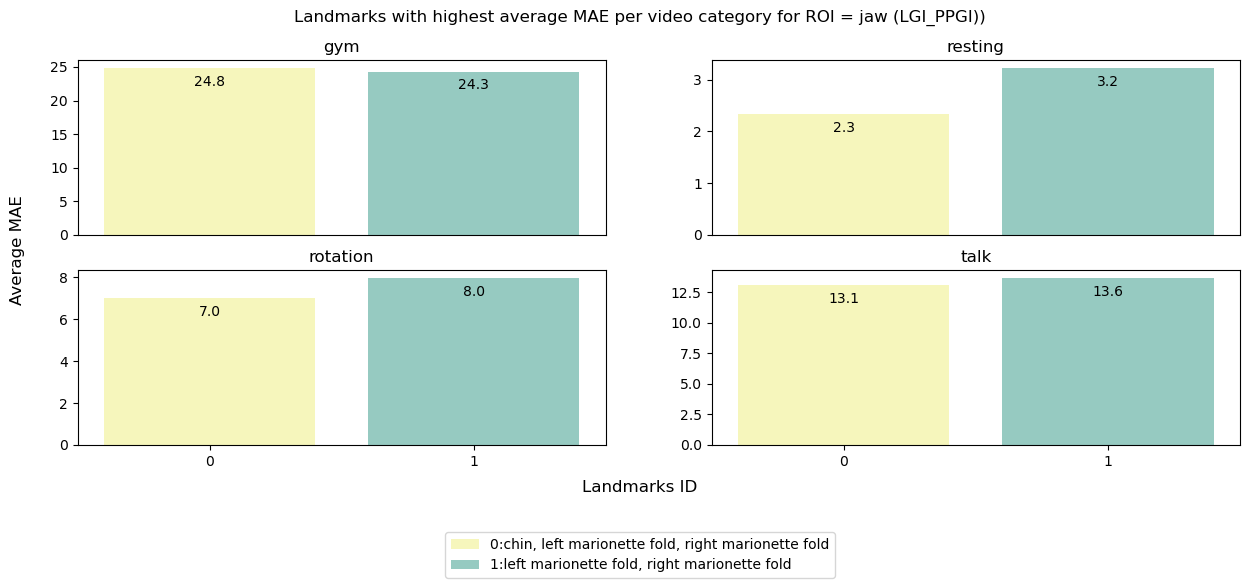

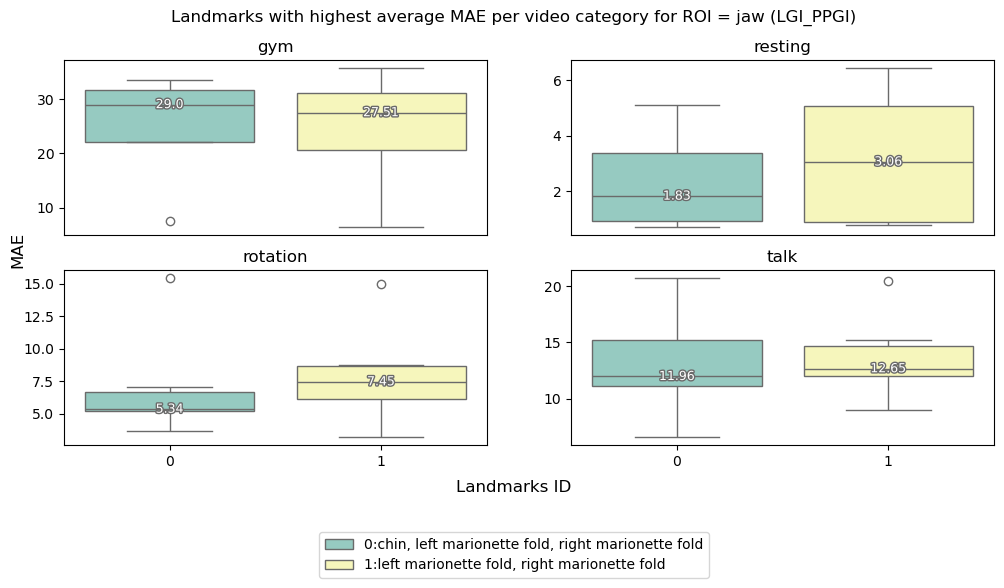

In [22]:
roi = 'jaw'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(2,2,figsize=(15,5))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(2,2,figsize=(12,5))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

## Bubble plot

In [24]:
roi = 'forehead'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
df

,method,dataset,videoIdx,videoFilename,RMSE,MAE,PCC,CCC,SNR,MAX,DTW,MAD,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks
0,cupy_CHROM,lgi_ppgi_forehead,0,alex_gym,[24.665734276197384],[14.951978165064103],[0.556308586949296],[0.519186543628614],[-4.341552955811867],[92.330078125],[5114.220703125],"[1.0986328125, 15.380859375, 4.7607421875, 8.0...","[101.0, 100.0, 97.0, 94.5, 93.0, 93.0, 93.0, 9...","[56.0302734375, 71.044921875, 86.7919921875, 6...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",207.187744,"(left_lower_lateral_forehead, right_lower_late..."
1,cupy_CHROM,lgi_ppgi_forehead,1,alex_resting,[1.4564609910056892],[0.948449337121212],[0.9288874300939538],[0.9252186060984902],[2.4762156521407603],[5.65234375],[45.38281250000001],"[0.732421875, 0.732421875, 0.3662109375, 0.732...","[68.5, 68.5, 68.0, 67.0, 67.0, 67.0, 67.0, 66....","[67.0166015625, 67.3828125, 67.0166015625, 66....","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",37.899232,"(left_lower_lateral_forehead, right_lower_late..."
2,cupy_CHROM,lgi_ppgi_forehead,2,alex_rotation,[11.16183337386451],[7.467860890858209],[0.4476846625268331],[0.1266407213086828],[-1.3279755832627416],[23.58984375],[472.96875],"[0.0, 0.732421875, 0.732421875, 1.46484375, 1....","[67.0, 67.5, 68.5, 69.0, 69.5, 70.0, 69.5, 68....","[70.3125, 69.580078125, 68.115234375, 65.91796...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",39.318321,"(left_lower_lateral_forehead, right_lower_late..."
3,cupy_CHROM,lgi_ppgi_forehead,3,alex_talk,[10.863372338143742],[6.6346180050872094],[-0.16593624246862412],[-0.09758584564439933],[-1.6864013493732484],[47.7861328125],[505.32421875],"[6.591796875, 8.4228515625, 17.9443359375, 17....","[82.0, 80.0, 72.5, 72.5, 73.5, 75.0, 76.5, 77....","[70.6787109375, 72.509765625, 83.8623046875, 7...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",51.663139,"(left_lower_lateral_forehead, right_lower_late..."
4,cupy_CHROM,lgi_ppgi_forehead,5,angelo_resting,[0.8917647370415115],[0.7225569385593217],[0.9497700804507646],[0.9302957690087279],[4.808465907886877],[1.953124999999993],[33.21777343749996],"[0.732421875, 0.3662109375, 0.0, 0.732421875, ...","[61.99999999999999, 61.99999999999999, 61.9999...","[61.5234375, 61.1572265625, 60.05859375, 58.59...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",34.208055,"(left_lower_lateral_forehead, right_lower_late..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,cupy_CHROM,lgi_ppgi_forehead,19,felix_talk,[16.05953200284144],[11.95528927364865],[0.06726873039510295],[0.05629895149009265],[-2.799732373473612],[52.736328125],[767.8095703125],"[0.732421875, 1.0986328125, 1.46484375, 1.4648...","[72.5, 73.0, 39.5, 41.5, 43.0, 46.0, 135.5, 75...","[79.833984375, 81.6650390625, 82.763671875, 83...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",36.694825,"(left_lower_lateral_forehead, lower_medial_for..."
106,cupy_CHROM,lgi_ppgi_forehead,20,harun_gym,[43.48358868875317],[34.52547611531987],[-0.03645185610785474],[-0.012989150807573667],[-5.694687276739966],[88.0966796875],[8457.0966796875],"[2.9296875, 1.8310546875, 8.4228515625, 12.084...","[99.5, 99.0, 98.5, 100.0, 102.5, 105.0, 105.5,...","[54.5654296875, 54.931640625, 58.2275390625, 5...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",136.892825,"(left_lower_lateral_forehead, lower_medial_for..."
107,cupy_CHROM,lgi_ppgi_forehead,21,harun_resting,[1.6398051166027254],[1.130645751953125],[0.8128156202686119],[0.7561883064855092],[1.0133167460662662],[7.8623046875],[65.0185546875],"[0.732421875, 0.732421875, 0.732421875, 0.7324...","[75.0, 75.5, 75.5, 7

In [ ]:
fig = px.scatter(df.query("year==2007"), x="gdpPercap", y="lifeExp",
	         size="pop", color="continent",
                 hover_name="country", log_x=True, size_max=60)
fig.show()

# MRI-NIRP

Reding  ../results/test_landmarks/MR_NIRP/MR_NIRP_each_landmark.h5


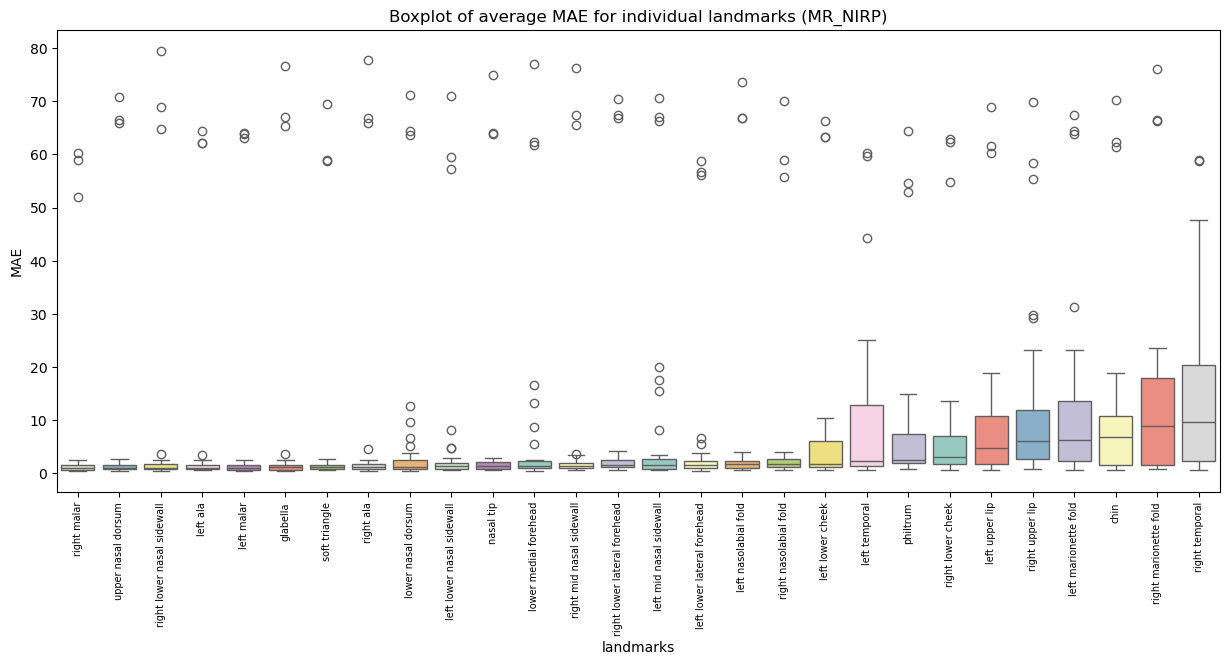

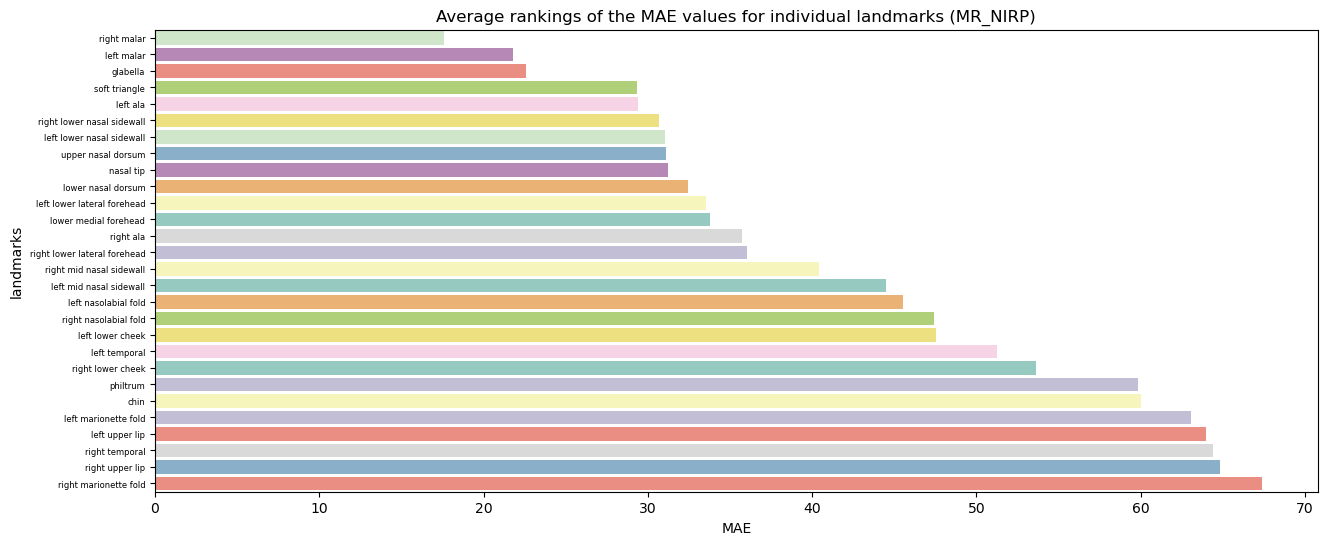

In [105]:
import pyVHR.analysis.pipelineLandmarks as custom_pipeline
import seaborn as sns
import matplotlib.pyplot as plt

dataset_name = 'MR_NIRP'
# path_results = f"../results/test_landmarks/h5/{dataset_name}/" # general path for cfg# general path for data
path_results = f"../results/test_landmarks/{dataset_name}/" # general path for cfg# general path for data

filenameH5 = path_results + f"{dataset_name}_each_landmark" + ".h5"
metric = 'MAE'

print("Reding ", filenameH5)
df =  pd.read_hdf(filenameH5)
_, ax1 = plt.subplots(1,1, figsize=(15,6))
_, ax2 = plt.subplots(1,1, figsize=(15,6))
df, grouped, rankings, box, bar = plot_each_landmark(df, metric, dataset_name, [ax1,ax2])

In [76]:
# Worst performing video on each video setting
df.query("landmarks == 'glabella'").query('method == "CHROM"').sort_values('MAE', ascending=False).groupby('video').head(1)

,method,dataset,videoIdx,sigFilename,videoFilename,RMSE,MAE,PCC,CCC,SNR,...,MAD,bpmGT,bpmES,bpmES_mad,timeGT,timeES,TIME_REQUIREMENT,landmarks,video,person
117,CHROM,MR_NIRP,3,,D:/datasets_rppg/MR-NIRP_indoor\Subject2_still...,[70.90241214109058],65.298443,[0.09001656014816867],[0.004298643728756673],[-4.638752449175407],...,"[26.3671875, 10.107421875, 43.06640625, 36.035...","[63.0, 63.0, 64.0, 64.5, 63.5, 61.0, 60.0, 61....","[100.634765625, 64.599609375, 114.697265625, 1...",,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",,glabella,still,Subject2
123,CHROM,MR_NIRP,6,,D:/datasets_rppg/MR-NIRP_indoor\Subject4_motio...,[2.4036987342950735],1.438802,[0.8491332262445875],[0.8473594672707601],[7.184540270655243],...,"[0.0, 0.87890625, 0.439453125, 0.0, 0.0, 0.878...","[76.0, 75.5, 74.0, 72.5, 70.0, 66.0, 62.500000...","[70.3125, 65.478515625, 61.962890625, 61.52343...",,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",,glabella,motion,Subject4


## Compare by video setting

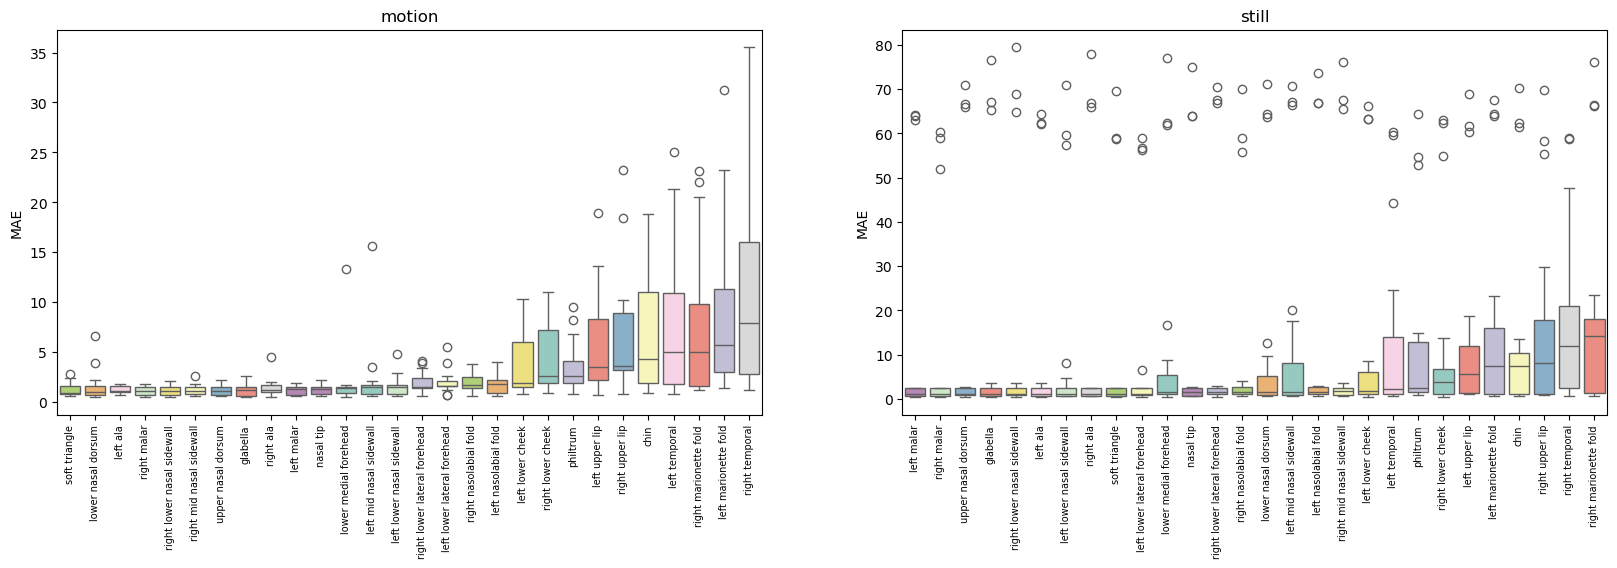

In [79]:
fig, axs = plt.subplots(1,2, figsize=(20,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
# fig.tight_layout()
videos = df.video.unique()
for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
   df_video = df.loc[df['video'] == videos[i]].copy()
   df_video = get_data_each_landmark(df_video, metric, dataset_name)
   _, box = plot_boxplot_each_landmark(df_video, metric, dataset_name, ax)
   box.set(title=videos[i], xlabel=None)
plt.show()

## Compare ROI by video setting

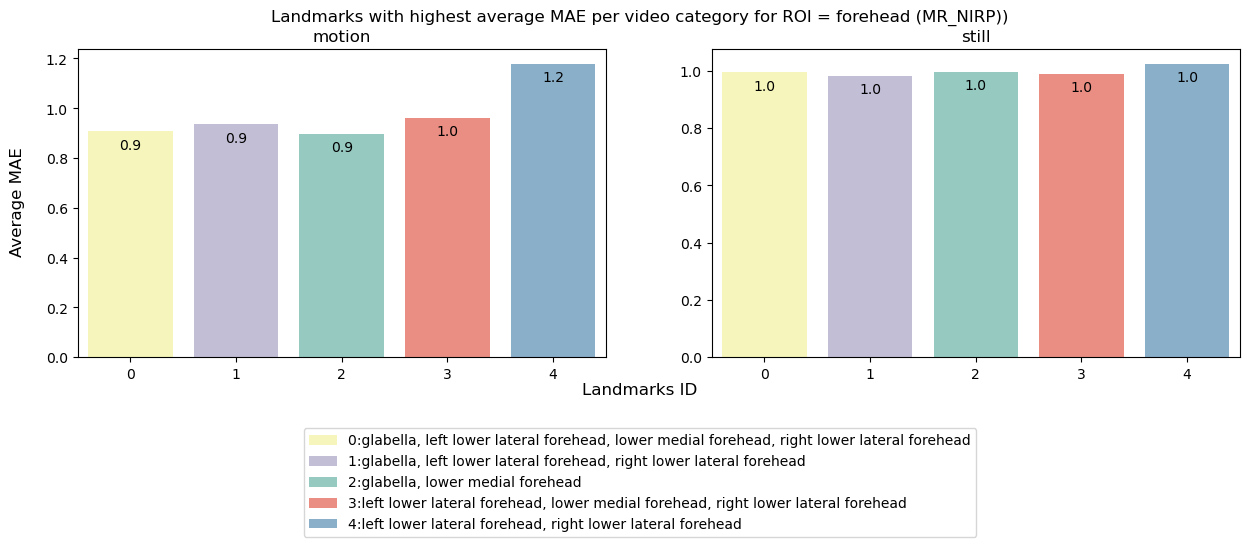

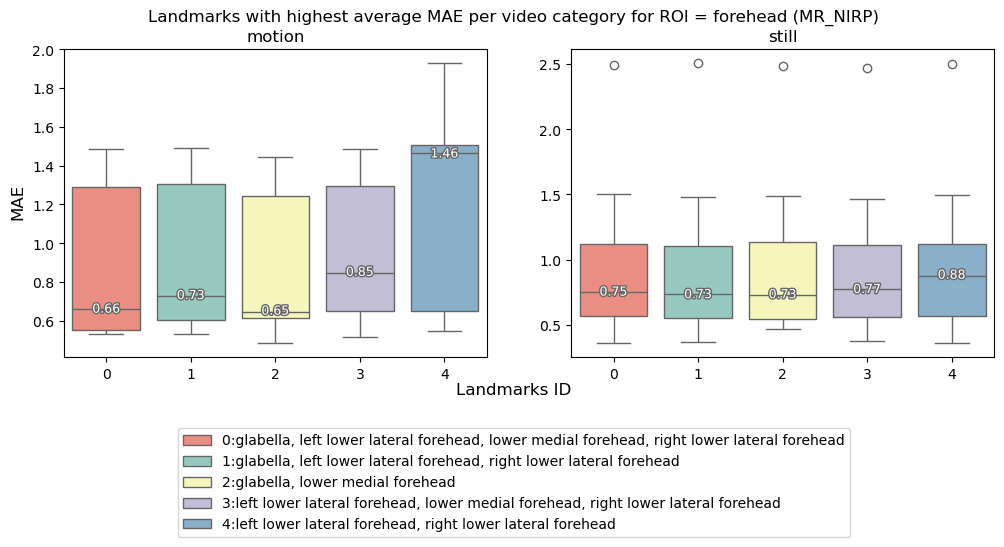

,landmarks,landmarks_id
45,"(glabella, left_lower_lateral_forehead, lower_...",0
0,"(glabella, left_lower_lateral_forehead, right_...",1
15,"(glabella, lower_medial_forehead)",2
30,"(left_lower_lateral_forehead, lower_medial_for...",3
60,"(left_lower_lateral_forehead, right_lower_late...",4


In [72]:
roi = 'forehead'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
forehead_params = [('left_lower_lateral_forehead', 'right_lower_lateral_forehead'), ('glabella', 'lower_medial_forehead'),  ('left_lower_lateral_forehead', 'lower_medial_forehead', 'right_lower_lateral_forehead'),('glabella', 'left_lower_lateral_forehead', 'right_lower_lateral_forehead'),('glabella', 'left_lower_lateral_forehead', 'lower_medial_forehead', 'right_lower_lateral_forehead')]
df = df.query('landmarks in @forehead_params')
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(1,2,figsize=(15,4))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

# print the mapping between landmarks and landmarks_id in the rankings dataframe
rankings[['landmarks','landmarks_id']].drop_duplicates().sort_values('landmarks_id')

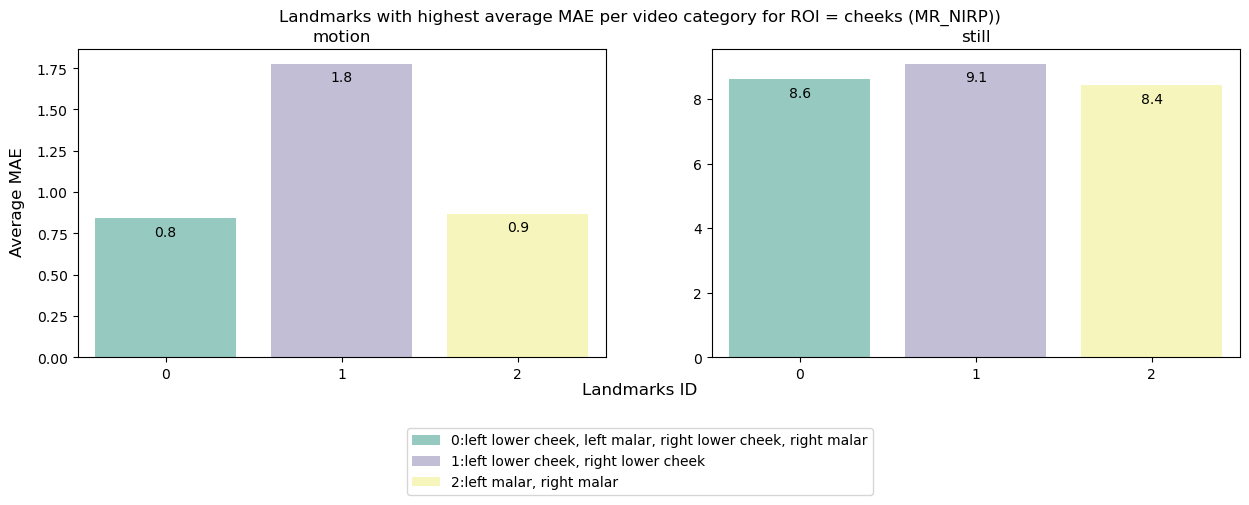

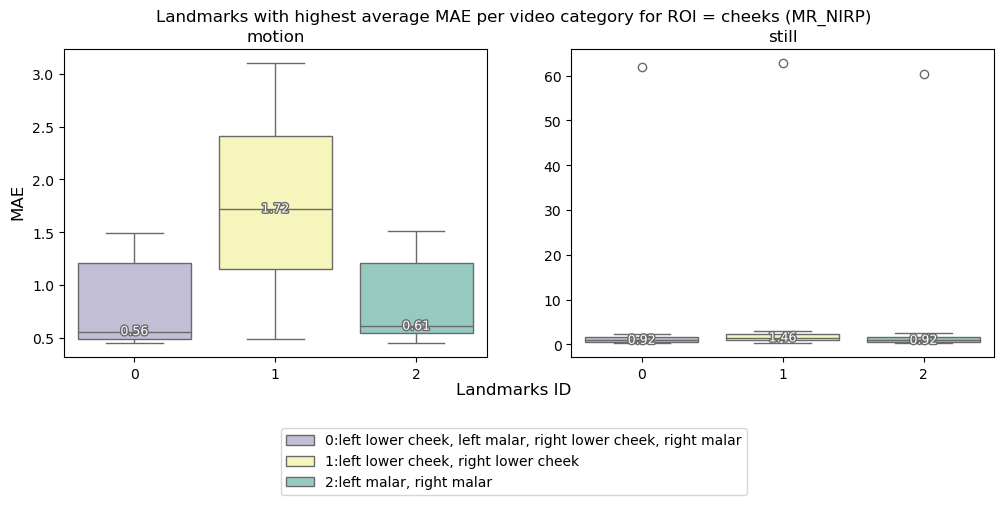

,landmarks,landmarks_id
30,"(left_lower_cheek, left_malar, right_lower_che...",0
15,"(left_lower_cheek, right_lower_cheek)",1
0,"(left_malar, right_malar)",2


In [73]:
roi = 'cheeks'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(1,2,figsize=(15,4))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

# print the mapping between landmarks and landmarks_id in the rankings dataframe
rankings[['landmarks','landmarks_id']].drop_duplicates().sort_values('landmarks_id')

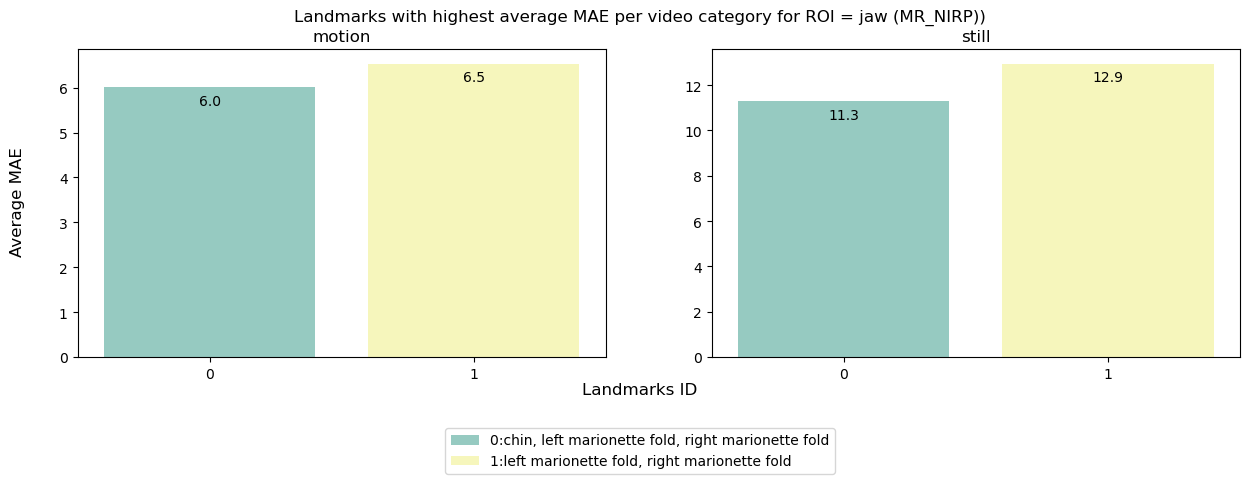

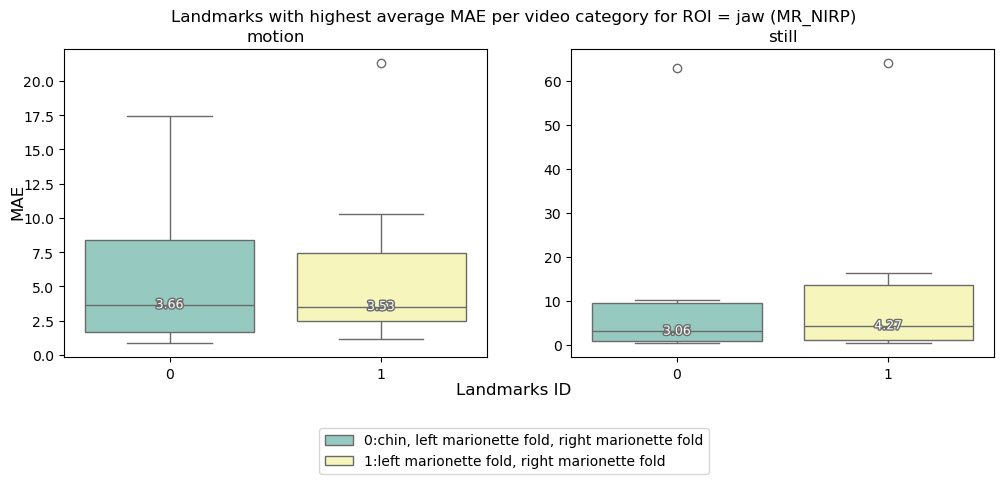

,landmarks,landmarks_id
0,"(chin, left_marionette_fold, right_marionette_...",0
15,"(left_marionette_fold, right_marionette_fold)",1


In [74]:
roi = 'jaw'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(1,2,figsize=(15,4))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

# print the mapping between landmarks and landmarks_id in the rankings dataframe
rankings[['landmarks','landmarks_id']].drop_duplicates().sort_values('landmarks_id')